## ARIMA

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import requests
import json
import datetime
import time
plt.style.use(style= "seaborn")
%matplotlib inline


In [ ]:
df = pd.read_csv("april.csv")
df = df[['open']][:50].copy()

df = df[::-1]
df = df[['open']].reset_index(drop=True)
#print(df)

In [2]:
# Read data from url
dateparse_url = lambda ts: (datetime.date.fromtimestamp(int(ts))).strftime("%Y%m%d%H%M")
data_url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1435699200&end=9999999999&period=14400'
with requests.get(data_url) as response:
    content = response.content.decode()
    eth_his = json.loads(content)

# Transform json to dataframe type and set parsed date to be index
eth_url_df = pd.DataFrame(eth_his)
eth_url_df["date"] = pd.to_datetime(eth_url_df["date"].apply(dateparse_url))
eth_url_df = eth_url_df.set_index("date")

# drop unuse column
eth_url_df = eth_url_df.drop(columns = ['high', 'low', 'close', 'volume', 'quoteVolume', 'weightedAverage'])

In [33]:
print("Please choose a start date to fit a trend of the ehereum\n", \
      "Using Example(Days):   2021-04-30\n", \
      "Using Example(Months): 2021-04\n", \
      "Using Example(Years):  2021\n")
split_date = input("Start Date: ")
data_fit = eth_url_df[split_date:"2021-04-30"]

data_test = eth_url_df["2021-05-01":"2021-05-31"]
data_fit = data_fit.groupby("date").first()
data_test = data_test.groupby("date").first()
#print(data_fit)
# Data Standardization & Create sequence feature
url_open_price = data_fit["open"].to_numpy()
data_test = data_test["open"].to_numpy() 


Please choose a start date to fit a trend of the ehereum
 Using Example(Days):   2021-04-30
 Using Example(Months): 2021-04
 Using Example(Years):  2021

Start Date: 2021-03-01


In [34]:
df = pd.DataFrame(url_open_price,columns = ['open'])
df2 = pd.DataFrame(data_test,columns = ['open'])
#print(df)

In [35]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.open.dropna())
print(f"Adf: {result[0]}")
print(f"p : {result[1]}")

Adf: 0.355553428021886
p : 0.9797545089295635


In [36]:
from pmdarima.arima.utils import ndiffs
ndiffs(df.open,test="adf")

1

## Original

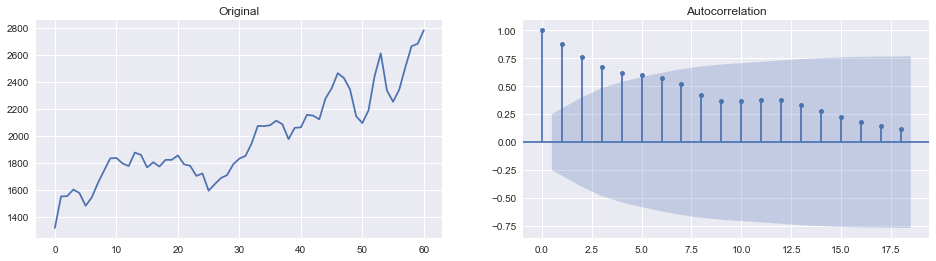

In [37]:

from statsmodels.graphics.tsaplots import plot_acf
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(df.open)
ax1.set_title("Original")
plot_acf(df.open,ax=ax2);

## Difference Once


In [38]:
diff = df.open.diff().dropna()

## Difference Twice

In [117]:
diff = df.open.diff().diff().dropna()

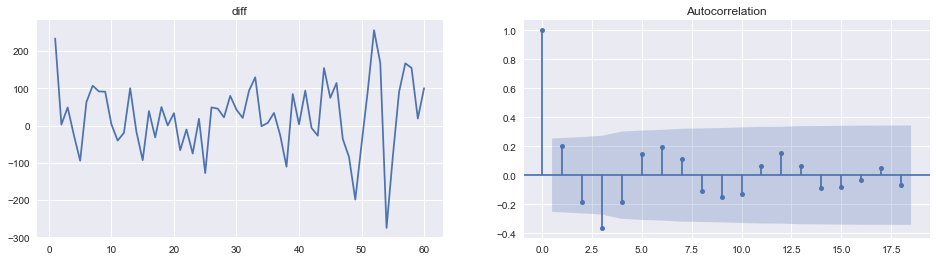

In [39]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("diff")
plot_acf(diff,ax=ax2);

## Get P Value

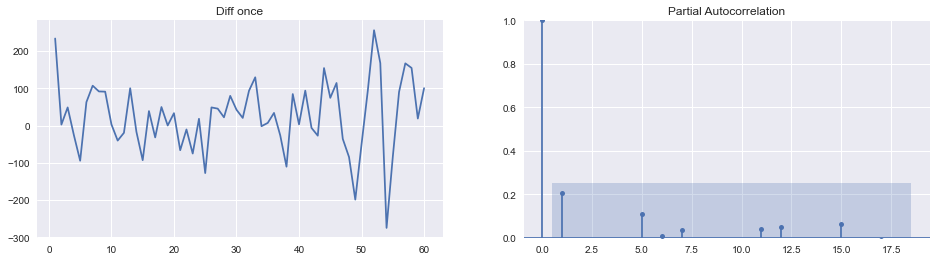

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Diff once")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2);

## Get Q Value

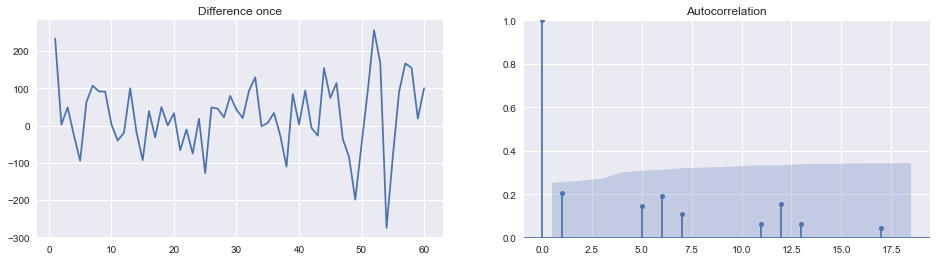

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))


ax1.plot(diff)
ax2.set_ylim(0,1)
ax1.set_title("Difference once")
plot_acf(diff,ax=ax2);

## Fit

In [42]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df.open,order = (1,1,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   open   No. Observations:                   61
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -357.215
Date:                Mon, 21 Jun 2021   AIC                            720.430
Time:                        22:28:53   BIC                            726.714
Sample:                             0   HQIC                           722.888
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0128      0.353      0.036      0.971      -0.679       0.704
ma.L1          0.3058      0.410      0.746      0.456      -0.497       1.109
sigma2      8696.6316   1456.431      5.971      0.0

In [43]:
res = pd.DataFrame(result.resid)
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
#ax1.plot(res)
#ax2.hist(res,density=True)

c:\users\kienn\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\kienn\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Mean Square Error:68857.682881622


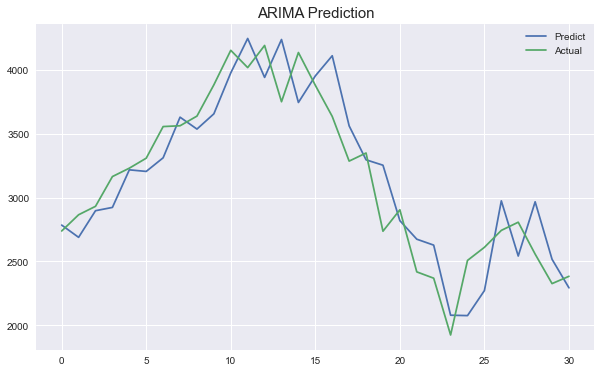

In [45]:
pred = result.forecast()
prediction = []
history = list(df.open)
mse = 0
for i in range(len(df2)):
    model = ARIMA(history,order = (2,1,1))
    result = model.fit()
    pred = result.forecast()
    prediction.append(pred[0])
    history.append(df2.open[i])
    mse += (df2.open[i]-pred[0])**2
mse /= len(df2)
#print(pred)
df3 = pd.DataFrame(list(prediction),columns = ['open'])
df3 = df3[['open']].copy()
df3 = df3[['open']].reset_index(drop = True)
#print(df2)

fig,(ax1) = plt.subplots(1,1,figsize=(10,6))

ax1.plot(df3,label='Predict')
ax1.set_title("ARIMA Prediction",fontsize = 15)

ax1.plot(df2,label ='Actual')
ax1.legend()

print("Mean Square Error:"+str(mse))


# Auto ARIMA


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1435.853, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1433.476, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1435.311, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1435.243, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1435.066, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.220 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -714.738
Date:                Sun, 20 Jun 2021   AIC                           1433.476
Time:                        23:44:06   BIC                           1439.034
Sample:                             0   HQIC                          1435.733
                                - 120                                       

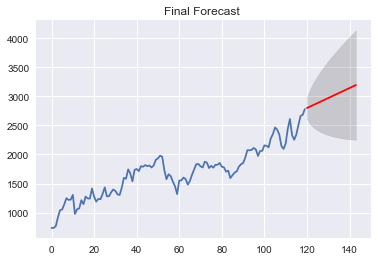

In [204]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df.values, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.values), len(df.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.values)
plt.plot(fc_series, color='red')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast ")
plt.show()